In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pywt
from matplotlib import cm
from watpy.coredb.coredb import *

In [ ]:
cdb = CoRe_db(r".\CoRe_DB")

In [ ]:
from CoRe_Dataloader_ECSG import get_dataset
ds = get_dataset()

In [ ]:
#Global variables

scale_min = 1
scale_max = 201
dscale = 0.1

In [ ]:
import math
import numpy as np
import matplotlib.pyplot as plt

def PlanckWindow(e, N):
    x = e*N
    j = math.floor(e*N)
    nby2=math.ceil(N/2)

    window = [1]*N
    window[0]=0
    for k in range(nby2):
        if(0<k and k<j):
            window[k]= 1./(1. + math.exp(x/k - x/(x-k)))
    for k in range(nby2,N):
         window[k]= window[N-k-1]
    return window

N = 800
e = .4
tolerance = 400

if(N*e > tolerance):
    print("N*e too large, exiting\n, N*e, tolerance")
else:
    win = PlanckWindow(e, N)
    xarray = np.arange(N)
    plt.plot(win)
    plt.show()


In [23]:
len(ds)

2365

In [ ]:
from scipy.signal import argrelextrema

def cut_at_lowest_envelope(hplus, hcross):
    # Cutting inspiral off
    oenv = np.sqrt(hplus**2 + hcross**2)
    cut_point = np.argmax(hplus)
    mhplus = hplus[cut_point:]
    env = oenv[cut_point:]
    envcut = argrelextrema(env,np.less)
    if len(envcut[0])==0:
        return mhplus
    return mhplus[envcut[0][0]:]
def wt(postmerger,sam_p):
    sam_f = 1/sam_p    
    scales = np.arange(scale_min, scale_max, dscale)

    #CWT on the gwf using the Morlet wavelet
    coefs, freqs = pywt.cwt(postmerger, scales, 'morl', sampling_period = sam_p)

    #Normalising the coefficient matrix using the Frobenius norm
    Z = (np.abs(coefs))/(np.linalg.norm(coefs))
    Z = Z[::5,::45][:,:400]
    return Z
def pad_width(Z,l = 400 ):
    cwidth = Z.shape[1]
    padb = np.zeros((l,int((l-cwidth)/2)))
    pada = np.zeros((l,int((l-cwidth)/2)))
    Z = np.concatenate((padb,Z,pada),axis = 1)
    cwidth = Z.shape[1]
    fpad = np.zeros((l,int((l-cwidth))))
    return np.concatenate((Z,fpad),axis = 1)
    

In [ ]:
time_con_f = 4.975e-6
gwf = cdb.sim["THC:0087"].run["R01"].data.read("rh_22")
strain = gwf[:,1]
sustrain = gwf[:,2]
env = gwf[:,6]     
pm_time = gwf[:,8]*time_con_f                         #converting to milliseconds
sam_p = (pm_time[-1] - pm_time[0])/len(pm_time)

In [ ]:
print(sam_p,1/sam_p)

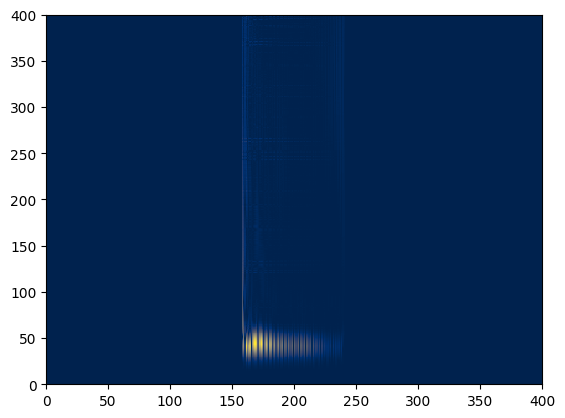

In [24]:
o = cut_at_lowest_envelope(strain,sustrain)
o1 = wt(o,sam_p)
o2 = pad_width(o1)
o2.shape
plt.pcolormesh(o2,cmap = cm.cividis)

In [ ]:
import plotly.express as px

In [22]:
fig = px.line(y = strain,template="plotly_dark")
fig.update_traces(line_color='#00ffff')
fig.show()

In [40]:
fig = px.imshow(np.flip(np.flip(o2),axis = 1),template="plotly_dark",color_continuous_scale=px.colors.sequential.Magma,aspect = "auto")
fig.update_layout(
autosize=False,
width=2000,
height=1000,
)
fig.show()